# Registr smluv - čištění dat
Data jsme už stáhli, velmi mírně pročistili, nyní se můžeme podívat, jak ona data vypadají, respektive jaké chyby v nich najdeme.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import os

## Načítání dat

In [2]:
vstupy = 'vstupy'

In [3]:
sml = pd.read_csv(os.path.join(vstupy, 'smlouvy.csv'))
sstr = pd.read_csv(os.path.join(vstupy, 'smluvni_strany.csv'))

In [4]:
sml.uzavreni = pd.to_datetime(sml.uzavreni)
sml.zverejneni = pd.to_datetime(sml.zverejneni)

### Odstranění starých verzí z dat
Každá smlouva může mít více verzí, my ty staré nemažeme při stahování, odstraníme je až tady.

In [5]:
sml = sml.loc[sml.idver == sml.groupby('idsml')['idver'].transform(max)]

In [6]:
uver = set(sml.idver.tolist()) # unikatni verze

In [7]:
sstr = sstr.loc[[True if j in uver else False for j in sstr.idver]]

## Počty

2200+ smluv

In [8]:
sml.shape

(2257, 12)

Ve `sstr` máme smluvní strany (nikoliv však nákupčího). Mělo by tam být tedy více řádek než počet smluv. Bohužel tomu tak není, protože často druhá smluvní strana chybí.

In [9]:
sstr.shape

(2240, 4)

Dostaneme se k tomu níže.

## Ceny
U smlouvy je možné uvést tři různé ceny - bez DPH, s DPH a cenu v cizí měně. Začněme to poslední možností.

### Zahraniční ceny

In [10]:
sml.loc[~sml.cena_cizi.isnull()].shape

(10, 12)

10 smluv má cizí měnu, ale...

In [11]:
sml.cena_cizi_mena.value_counts()

CZK    5
EUR    5
Name: cena_cizi_mena, dtype: int64

...polovina z nich jsou ceny v korunách, což je chyba, protože cena těchto smluv je správně uvedená v kolonkách pro cenu s/bez DPH a pak jako cizí měna je uvedeno "0 CZK"

In [12]:
sml.loc[sml.cena_cizi_mena == 'CZK', ['cena_cizi', 'cena_cizi_mena']]

,cena_cizi,cena_cizi_mena
758,0.0,CZK
1137,0.0,CZK
1402,0.0,CZK
1715,0.0,CZK
2311,0.0,CZK


**Návrh: 1) Zrušte možnost vyplnit nulovou cenu smlouvy, 2) zrušte možnost vyplnit zahraniční měnu jako 'CZK'**

### České ceny

**cena - nemame moc symetricky data k s/bez dph**

Podívejme se tedy na všechny smlouvy, které nemají uvednou cenu v cizí měně.

In [13]:
ceny = sml.loc[sml.cena_cizi_mena.isin([np.nan, 'CZK'])]

In [14]:
pd.crosstab(ceny.cena_bezdph.isnull(), ceny.cena_sdph.isnull())

cena_sdph,False,True
cena_bezdph,,
False,574,467
True,840,371


Tahle tabulka říká asi všechno co se týče dostupnosti cen v metadatech. Řádky signalizují počet smluv s cenou bez DPH, sloupce počty smluv s DPH.

Takže tady vidíme, že **jen 371 smluv má obě ceny, 1307 smluv (840+467) má právě jednu cenu. A zbytek, 574 smluv nemá žádnou informaci o ceně.**

Nejde bohužel říct, že krom těch 574 smluv je vše v pořádku. Není to tak jednoduché. Když má člověk právě jednu cenu - ať už s nebo bez DPH, nemůže celý dataset konzistentně agregovat.

Též nejde říct, že všech 574 smluv bez cen neplatných (TODO: přidej komentáře o začerňování, Budvaru atp.)

Primitivní agregace by naznačovala, že celková hodnota smluv je zatím přes 2.5 miliardy. (Neberte to číslo přesně, je tam aproximace kvůli chybějícím datům, viz výše.)

In [15]:
ceny[['cena_bezdph', 'cena_sdph']].mean(axis=1).sum()/10**9

2.65890023563

**Návrh: když je zadaná cena smlouvy bez nebo s DPH, vynuťte, aby byla zadaná i druhá cena.**

### Kdo neuvádí ceny
Je celkem jednoduché podívat se, kdo že to neuvádí ceny. Může to být legitimní důvod (legislativní výjimka, u Budvaru), může jít o obfuskaci.

In [16]:
# sml.loc[sml.cena_bezdph.isnull() & sml.cena_sdph.isnull()].\
# groupby(['ico', 'subjekt']).count()

In [17]:
uni = pd.DataFrame(index=sml.ico.unique(), columns = ['subjekt', 'smluv', 'bezcen'])

for ic in sml.ico.unique():
    nz = sml.loc[sml.ico == ic].subjekt.iloc[0]
    n = len(sml.loc[sml.ico == ic, :])
    bc = sml.loc[sml.ico == ic, ['cena_bezdph', 'cena_sdph']].isnull().all(axis=1).sum()

    uni.loc[ic] = [nz, n, bc]

# uni.sort_values(by='smluv', ascending=False).to_csv('bezcen.csv', encoding='utf8')

assert len(uni) == len(sml.ico.unique())

In [18]:
uni.sort_values(by='smluv', ascending=False).head(10)

,subjekt,smluv,bezcen
70890749,KruV - RS (Kraj Vysočina),244,4
60162694,Fakturace (Ministerstvo obrany),216,15
70891508,Liberecký kraj,154,1
60609460,Olomoucký kraj,108,0
64190,Thomayerova nemocnice,71,51
70890692,MSK registr smluv (Moravskoslezský kraj),69,7
209805,Masarykův onkologický ústav,56,0
47443936,"Základní škola Třebíč, Cyrilometodějská 22",52,27
64581,Hlavní město Praha,33,10
65269705,Fakultní nemocnice Brno,30,4


Takže nějaké instituce mají čistý štít, ale třeba Thomayerka u nás doma v Krči má většinu smluv bez cen. To může být u zdravotnického materiálu možná i pochopitelné. (Nevysvětluje to ale proč nemocnice v Brně nefunguje podobně.)

## Smluvní strany

Máme tedy x smluv, čekali bychom tedy alespoň x společností na druhé straně smlouvy

In [19]:
print(len(sml), len(sstr))

2257 2240


Máme jich ale naopak o pár míň. A to protože **69 smluv nemá žádné smluvní strany**. To je možné, protože registr nejspíš vynucuje alespoň jednu smluvní stranu, ale spousta zadavatelů mezi smluvní strany počítá i samotného objednavatele. Proto je spousta smluv bez smluvní strany.

**Návrh: Vynuťte, aby u smlouvy byla zadaná alespoň jedna smluvní strana s IČO rozdílným od objednatele.**

In [20]:
ustr = set(sstr.idsml.tolist())

sml.idsml.apply(lambda x: x not in ustr).sum()

69

### Chybí IČO
IČO je celkem jednoduchý způsob jak napárovat data na jiné systémy (např. ARES). Proto je problém, že spousta smluvních stran nemá uvedené IČO.

In [21]:
100 * sstr.ico.isnull().sum() / len(sstr)

16.071428571428573

**Každá šestá smluvní strana, 16 %, nemá uvedené IČO.**

Co to v reálu způsobuje? Když se podíváme na smlouvy se smluvními stranami bez uvedeného IČO, můžeme spočítat, jakou mají hodnotu.

In [22]:
bezic = sml.loc[sml['idsml'].isin(sstr.loc[sstr.ico.isnull(), 'idsml'].values), :]
bezic.shape

(346, 12)

In [23]:
bezic[['cena_bezdph', 'cena_sdph']].mean(axis=1).sum()/10**6

84.292314605000001

Jde tedy o 84 milionů (v kontextu 2.5 miliard). Přeberte si sami, jak významný je to problém.

**Návrh: Vynuťte uvádění identifikačního čísla smluvní strany s možností opt outu (pro soukromníky bez IČO/DIČ).**

### Názvy smluvní stran
Někdo by mohl navrhnout, že místo IČO bych mohl použít názvy smluvních stran. S tím jsou ale dva problémy.

1. Názvy nejsou unikátní, třeba Kotěhůlky asi jsou, ale Obec Lhota, těch je několik.
2. Názvy nejsou konstantní v čase. Firmy se přejmenovávají, lidi dělají překlepy atd. Např. Sodexo, prodejce stravenek, je na spoustě smluv jako Sodexho, i když se tak už spoustu let nejmenuje.

In [24]:
# sstr.loc[sstr.subjekt.str.contains('Sodexho') | sstr.subjekt.str.contains('Sodexo')]

### Grafíky

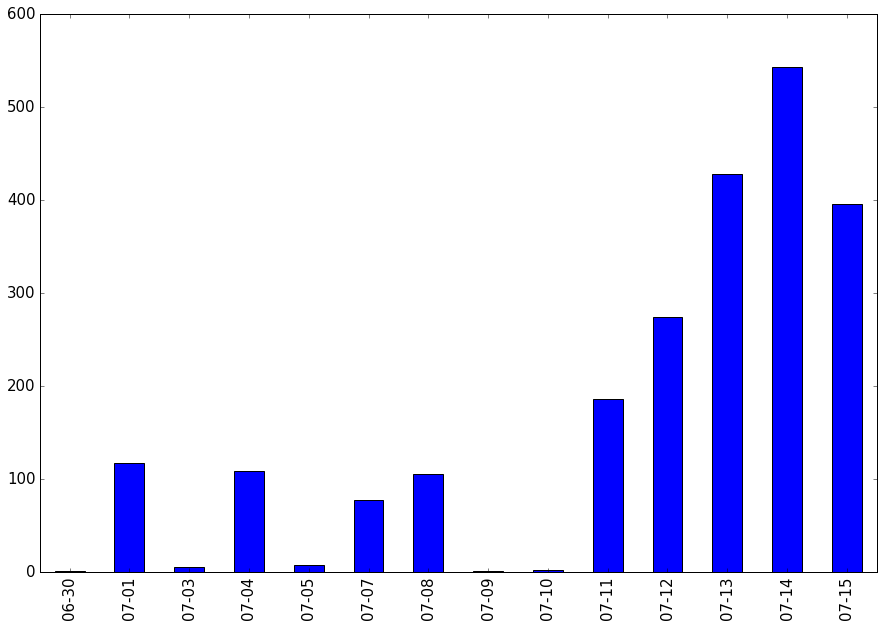

In [25]:
sml.zverejneni.apply(lambda x: x.strftime('%m-%d')).\
value_counts().sort_index().plot(kind='bar', figsize=(15,10), fontsize=15)

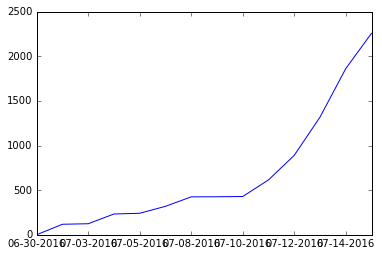

In [26]:
sml.zverejneni.apply(lambda x: x.strftime('%m-%d-%Y')).value_counts().\
sort_index().cumsum().plot()

### Implicitní DPH
Máme-li hodnoty bez a s DPH, můžeme spočítat implicitní sazbu DPH. V následující tabulce je sazba a pak počet smluv s tou sazbou.

In [27]:
(100*((sml.cena_sdph / sml.cena_bezdph)-1)).dropna().round(2).value_counts()

 21.00        344
 0.00         138
 15.00         23
 10.00         18
-9.09          14
 21.01          4
 26.58          2
 20.84          2
-88.52          1
-87.33          1
 29.41          1
 23.59          1
 22.51          1
 20.88          1
 120900.00      1
 19.82          1
 18.58          1
-85.00          1
 14.99          1
 0.04           1
 3.03           1
 31.44          1
 1110.00        1
 0.37           1
 10.04          1
 120.98         1
-79.00          1
 19.65          1
 22.22          1
 0.88           1
 19.00          1
 20.27          1
 0.12           1
 20.00          1
 0.47           1
 10.06          1
 0.19           1
dtype: int64

Sazby 21 %, 15, 10, 0 nebo 20 jde docela dobře vysvětlit. Zbytek bude trochu těžší. Ono i nekulaté sazby jdou vysvětlit, třeba u rámcové smlouvy, kde různé položky mají ruzné sazby. Můžeme se ale podívat na trochu extrémnější sazby. Třeba ty záporné.

In [28]:
(sml.cena_sdph < sml.cena_bezdph).sum()

18

18 smluv má cenu s DPH nižší než bez DPH, to je očividně problém. Někde třeba ukládají jen onu daň do položky ceny s DPH.

**Návrh: Vynuťte, aby cena s DPH byla alespoň tak vysoká jako cena bez DPH**

In [29]:
((sml.cena_sdph / sml.cena_bezdph - 1) > .21).sum()

105

105 smluv pak má sazbu vyšší než 21 % (což moc nejde). Důvodů může být spousta.

**Návrh: Ukažte vkladateli implicitní hodnotu DPH. Třeba si sám uvědomí, že jde o chybu.**

### Záporné ceny
Občas jsou uvedeny záporné ceny, co to asi tak mohlo být.

In [30]:
sml.loc[(sml.cena_bezdph < 0) | (sml.cena_sdph < 0)]

,idsml,idver,zverejneni,uzavreni,subjekt,ico,cena_bezdph,cena_sdph,cena_cizi,cena_cizi_mena,predmet,odkaz
730,3165,3285,2016-07-12 08:22:57,2012-10-12,Vyšší policejní škola a Střední policejní škol...,48135453,NaN,-1.24,NaN,NaN,"Pha 9,Pod Táborem-nápoj.automaty_02",https://smlouvy.gov.cz/smlouva/3285
1339,5737,5881,2016-07-13 15:02:06,2016-07-13,Město Lysá nad Labem,239402,NaN,-652190.00,NaN,NaN,Dodávka modulární dráhy pumptrack v Lysé nad L...,https://smlouvy.gov.cz/smlouva/5881
1346,5769,5913,2016-07-13 15:18:12,2016-07-14,Město Lysá nad Labem,239402,NaN,-477950.00,NaN,NaN,PD komunitní centrum č.p. 13,https://smlouvy.gov.cz/smlouva/5913


**Návrh: Vynuťte pozitivní hodnotu pro jakoukoliv z cen**